In [5]:
import pandas as pd
import numpy as np
from utils.statistics import *

csv_path = '/media/all/D4/output/2012-01-01T000000_2018-01-01T000000/training/'
train = pd.read_csv(csv_path + 'meta_data.csv', sep=",", parse_dates=["start","end"], index_col="id")

### Class counts
Examine the imbalance of flare strengths.

*flux_to_class* maps the peak_flux of a flare to one of the following descriptors:
**free** = 1e-9, **B** >= 1e-7, **C** >= 1e-6, **M** >= 1e-5, and **X** >= 1e-4

The "unique ARs" describes from how many different active region numbers (noaa_num) the flares come from.

In [2]:
noaa_nums = np.unique(train["noaa_num"])
classes_samples = [flux_to_class(pf, only_main=True) for pf in train["peak_flux"]]
max_classes_ARs = [flux_to_class(max(train[train["noaa_num"] == noaa_num]["peak_flux"]), only_main=True) for noaa_num in noaa_nums]
classes, counts_samples = np.unique(classes_samples, return_counts=True)
classes, counts_ARs = np.unique(max_classes_ARs, return_counts=True)
pd.DataFrame(data={"samples":counts_samples, "unique ARs":counts_ARs}, index=classes)

,samples,unique ARs
B,2175,119
C,4790,412
M,568,97
X,28,13
free,3593,450


### Detector degradation
Here we coarsely examine the degradation of the AIA and HMI detectors over the 6-year period of the data

This is the (very noisy) data:


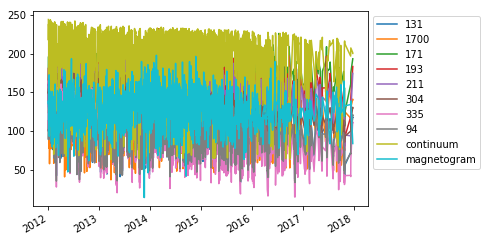

And by averaging aggressively you can see some trends in it:


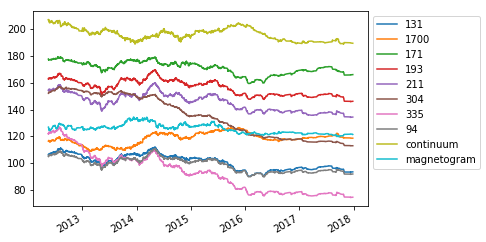

In [161]:
import os
from skimage import io
import statistics
from matplotlib import pyplot as plt

images_path = '/media/all/D4/publish/training/'

# just picking the quiet regions might reduce the noise a bit
train_degrad = train.loc[train['peak_flux'] == 1e-9]
train_degrad = train_degrad.sort_values(by=['start'])
dict_degrad = {'date': [], '94': [], '131': [], '171': [], '193': [], '211': [], '304': [], '335': [], '1700': [], 'continuum': [], 'magnetogram': []}
wavelengths = list(dict_degrad.keys())
wavelengths = wavelengths[1:]
for row in train_degrad.iterrows():
    pixel_vals = {}
    ar_nr, p = row[0].split("_", 1)
    path = os.path.join(images_path, ar_nr, p)
    if os.path.isdir(path):
        for img in [name for name in os.listdir(path) if name.endswith('.jpg')]:
            img_wavelength = os.path.splitext(img)[0].split("__")[1]
            im = io.imread(os.path.join(path, img)) # Can be many different formats.
            mid = im.shape[0] // 2
            im = im[mid - 20:mid + 20,mid - 20:mid + 20]
            if img_wavelength not in pixel_vals:
                pixel_vals[img_wavelength] = []
            pixel_vals[img_wavelength].append(np.mean(im))
        for wl in wavelengths:
            if wl not in pixel_vals:
                if len(dict_degrad[wl]) > 0:
                    dict_degrad[wl].append(dict_degrad[wl][-1])
                else:
                    dict_degrad[wl].append(0)
            else:
                dict_degrad[wl].append(sum(pixel_vals[wl]) / float(len(pixel_vals[wl])))
        dict_degrad['date'].append(row[1]['start'])

display_dict = dict(dict_degrad)
del display_dict['date']
df_degrad = pd.DataFrame(data=display_dict, index=dict_degrad['date'])
df_degrad = df_degrad.sort_index(ascending=True)
print('This is the (very noisy) data:')
degrad_plot = df_degrad.plot()
degrad_plot.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()
print('And by averaging aggressively you can see some trends in it:')
degrad_plot = df_degrad.rolling(window=200).mean().plot()
degrad_plot.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

### Divergence HEK vs GOES peak flux
Difference of manual labels by experts (HEK) with the recorded flux on the sun (GOES) on a **log** scale.
The purpose of this is to examine the stability of the labels.

MSE: 0.0016047341898903556
L1:  0.022736040873996673
Max: 0.07058107428570715


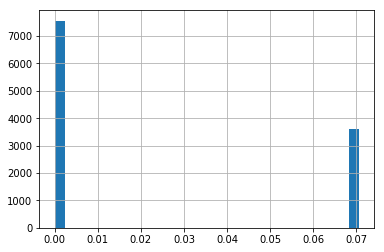

In [6]:
train['flux_from_hek'] = [class_to_flux(t) / 0.85 for t in train['type']]
# 0.85 = correction factor, see https://www.ngdc.noaa.gov/stp/satellite/goes/doc/GOES_XRS_readme.pdf
logdiff = np.log10(train['flux_from_hek']) - np.log10(train['peak_flux'])
mse = (logdiff ** 2).mean()
l1 = abs(logdiff).mean()
print(f'MSE: {mse}')
print(f'L1:  {l1}')
print(f'Max: {max(abs(logdiff))}')
abs(logdiff).hist(bins=30)